In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

import warnings
warnings.filterwarnings(action='ignore')

# Part 1: Classification with Single Model

# Performance Evaluation Function

In [3]:
def perf_eval(cm: np.array):
    num_classes = cm.shape[0]
    tpr = np.zeros(num_classes)
    tnr = np.zeros(num_classes)

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        tpr[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr[i] = tn / (tn + fp) if (tn + fp) > 0 else 0

    # 전체 정확도 계산
    overall_acc = np.trace(cm) / np.sum(cm)
    # 평균 BCR 계산
    avg_bcr = np.mean(np.sqrt(tpr * tnr))

    return overall_acc, avg_bcr

In [4]:
perf_table = pd.DataFrame(
    data    = np.zeros(shape=(3,2)),
    index   = ["MLR", "CART", "ANN"],
    columns = ["Accuracy", "BCR"]
)

In [5]:
perf_table

,Accuracy,BCR
MLR,0.0,0.0
CART,0.0,0.0
ANN,0.0,0.0


Load the dataset and set the input/target indices

In [6]:
# Load the data & Preprocessing
Earthquake_Damage = pd.read_csv("/content/drive/MyDrive/Earthquake_Damage.csv")

In [7]:
# 결측치 확인
missing_values = Earthquake_Damage.isnull().sum()

# 결측치가 있는 열 출력
print("결측치가 있는 열:")
print(missing_values[missing_values > 0])

결측치가 있는 열:
Series([], dtype: int64)


In [47]:
print(Earthquake_Damage['damage_grade'].unique())
print(Earthquake_Damage['damage_grade'].value_counts())

[3 2 1]
damage_grade
2    148259
3     87218
1     25124
Name: count, dtype: int64


In [8]:
df = Earthquake_Damage.sample(n=10000, random_state=42)

In [9]:
df

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
111801,1023112,10,1224,11128,1,20,7,3,t,r,...,0,0,0,0,0,0,0,0,0,2
91817,64407,22,1101,12483,2,60,7,6,t,r,...,0,0,0,0,0,0,0,0,0,2
251661,967834,26,39,11440,2,50,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
205479,36669,8,1073,2743,3,50,7,6,o,r,...,0,0,0,0,0,0,0,0,0,2
22618,242842,6,706,7959,2,15,8,4,t,r,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152793,404395,10,1127,8866,2,30,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
153089,242122,26,74,10745,2,5,5,6,t,r,...,0,0,0,0,0,0,0,0,0,2
144559,337564,6,724,3234,2,0,4,5,t,r,...,0,0,0,0,0,0,0,0,0,2
249097,659373,30,794,3742,2,35,10,4,t,r,...,0,0,0,0,0,0,0,0,0,2


In [10]:
print(df['damage_grade'].unique())
print(df['damage_grade'].value_counts())

[2 3 1]
damage_grade
2    5742
3    3268
1     990
Name: count, dtype: int64


In [11]:
y = df['damage_grade']
X = df.drop(['building_id', 'damage_grade'], axis=1)

In [12]:
# numeric 형식이 아닌 변수들 식별
non_numeric_cols = X.select_dtypes(exclude=['number']).columns

# 1-hot encoding 적용
X_encoded = pd.get_dummies(X, columns=non_numeric_cols, dtype=int)

# 결과 확인
print(X_encoded.head())

        geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
111801              10            1224           11128                    1   
91817               22            1101           12483                    2   
251661              26              39           11440                    2   
205479               8            1073            2743                    3   
22618                6             706            7959                    2   

        age  area_percentage  height_percentage  has_superstructure_adobe_mud  \
111801   20                7                  3                             0   
91817    60                7                  6                             0   
251661   50                6                  5                             0   
205479   50                7                  6                             0   
22618    15                8                  4                             0   

        has_superstructure_mud_mortar_

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded,
                                                    y,
                                                    train_size=0.6,
                                                    shuffle=False,
                                                    random_state=12345)

In [14]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp,
                                                    y_temp,
                                                    test_size=0.5,
                                                    shuffle=False,
                                                    random_state=12345)

In [15]:
X_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
111801,10,1224,11128,1,20,7,3,0,1,0,...,0,0,0,0,0,0,0,0,1,0
91817,22,1101,12483,2,60,7,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
251661,26,39,11440,2,50,6,5,0,0,0,...,0,0,0,0,0,0,0,0,1,0
205479,8,1073,2743,3,50,7,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
22618,6,706,7959,2,15,8,4,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17856,29,1086,612,2,30,9,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
32236,26,1050,11056,2,15,6,5,0,0,0,...,0,0,0,0,0,0,1,0,0,0
211550,17,1313,9066,3,40,9,7,0,1,0,...,0,0,0,0,0,0,0,0,1,0
20052,25,1335,117,1,15,6,3,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
X_valid

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
243599,26,74,8647,2,20,3,7,0,1,0,...,0,0,0,0,0,0,0,0,1,0
52972,10,712,7102,2,10,6,5,0,1,1,...,0,0,0,0,0,0,0,0,1,0
19025,13,606,11956,2,30,21,4,0,1,0,...,0,0,0,0,0,0,0,0,1,0
53891,8,463,8236,2,5,16,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54793,4,910,10853,2,55,5,4,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201219,17,367,8415,3,35,14,8,0,1,0,...,0,0,0,0,0,0,0,0,1,0
61132,20,481,4950,2,25,8,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
46376,4,454,6270,2,25,11,4,0,1,0,...,0,0,0,0,0,0,0,0,1,0
17088,7,129,11796,2,0,11,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
X_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
27536,4,1202,3272,2,5,7,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
124278,7,859,2341,1,5,3,2,0,1,0,...,0,0,0,0,0,0,0,0,1,0
59369,4,699,5100,2,10,7,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
47475,20,826,1398,1,20,4,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
69220,3,574,7980,3,35,7,8,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152793,10,1127,8866,2,30,5,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
153089,26,74,10745,2,5,5,6,0,1,0,...,0,0,0,0,0,0,1,0,0,0
144559,6,724,3234,2,0,4,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
249097,30,794,3742,2,35,10,4,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
print(y_train.value_counts())
print(y_valid.value_counts())
print(y_test.value_counts())

damage_grade
2    3430
3    1973
1     597
Name: count, dtype: int64
damage_grade
2    1144
3     649
1     207
Name: count, dtype: int64
damage_grade
2    1168
3     646
1     186
Name: count, dtype: int64


## Model 1: Multinomial logistic regression

In [19]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 규제 강도에 대한 후보값
    'solver': ['newton-cg', 'lbfgs', 'sag'],  # 최적화 알고리즘에 대한 후보값
    'max_iter': [100, 300]  # 반복 횟수에 대한 후보값
}

In [20]:
# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_logistic_params = None
best_BCR = 0
best_logistic_model = None

# 각 파라미터 조합에 대해 모델 훈련 및 평가
for params in grid:
    model = LogisticRegression(random_state=12345, multi_class='multinomial', **params)
    model.fit(X_train, y_train)

    # 검증 데이터로 예측 수행
    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 최고의 BCR 값을 가진 모델 및 파라미터 저장
    if BCR > best_BCR:
        best_BCR = BCR
        best_logistic_params = params
        best_logistic_model = model


# 최적의 하이퍼파라미터 조합 출력
print("Best parameters:", best_logistic_params)
print("Best BCR on validation data:", best_BCR)

cm = confusion_matrix(y_valid, best_logistic_model.predict(X_valid))
print("Confusion matrix:\n", cm)

Best parameters: {'C': 10, 'max_iter': 300, 'solver': 'newton-cg'}
Best BCR on validation data: 0.4994382791146987
Confusion matrix:
 [[ 74 124   9]
 [ 35 984 125]
 [  3 510 136]]


In [21]:
# 테스트 데이터에 대한 최적 모델 평가
y_pred = best_logistic_model.predict(X_test)
log_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", log_cfm)

Confusion matrix:
 [[  60  120    6]
 [  41 1024  103]
 [   1  514  131]]


In [22]:
perf_table.iloc[0,:] = perf_eval(cm=log_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.0000,0.000000
ANN,0.0000,0.000000


## Model 2: Classification Tree

In [23]:
# Tree parameter settings
criterion = ["gini", "entropy"]
min_split = [10, 25, 50]
max_depth = [None, 10, 20, 30]
min_samples_leaf = [10, 20, 40]

param_grid = {
    'criterion': criterion,
    'min_samples_split': min_split,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

In [24]:
# 하이퍼파라미터 조합 생성
from itertools import product
param_combinations = list(product(
    param_grid['criterion'],
    param_grid['min_samples_split'],
    param_grid['max_depth'],
    param_grid['min_samples_leaf']
))

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_cart_params = None
best_BCR = 0
best_cart_model = None

# 각 하이퍼파라미터 조합에 대해 모델 훈련 및 평가
for params in param_combinations:
    criterion, min_samples_split, max_depth, min_samples_leaf = params
    model = DecisionTreeClassifier(
        criterion=criterion,
        min_samples_split=min_samples_split,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=12345
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    if BCR > best_BCR:
        best_BCR = BCR
        best_cart_params = params
        best_cart_model = model

# 최적 하이퍼파라미터 출력
best_criterion, best_split, best_depth, best_min_samples_leaf = best_cart_params
print("Best criterion:", best_criterion)
print("Best min_samples_split:", best_split)
print("Best max_depth:", best_depth)
print("Best min_samples_leaf:", best_min_samples_leaf)
print("Best BCR on validation data:", best_BCR)

cm = confusion_matrix(y_valid, best_cart_model.predict(X_valid))
print("Confusion matrix:\n", cm)

Best criterion: gini
Best min_samples_split: 10
Best max_depth: None
Best min_samples_leaf: 20
Best BCR on validation data: 0.6262202798801074
Confusion matrix:
 [[ 84 119   4]
 [ 64 884 196]
 [  6 326 317]]


In [25]:
# 테스트 데이터에 대한 최적 모델 평가
y_pred = best_cart_model.predict(X_test)
cart_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cart_cfm)

Confusion matrix:
 [[ 75 106   5]
 [ 60 921 187]
 [  8 319 319]]


In [26]:
perf_table.iloc[1,:] = perf_eval(cm=cart_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.0000,0.000000


## Model 3: Artificial Neural Network

In [27]:
param_grid = {
    'hidden_layer_sizes': [(25,), (50,), (100,), (25,25)],  # 은닉층의 노드 수
    'learning_rate_init': [0.005, 0.01, 0.1],  # 학습률
    'activation': ['logistic', 'tanh', 'relu'],  # 활성화 함수
}

In [28]:
# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_ann_params = None
best_BCR = 0
best_ann_model = None

# 각 파라미터 조합에 대해 모델 훈련 및 평가
for params in grid:
    model = MLPClassifier(random_state=12345, **params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 최고의 BCR 값을 가진 모델 및 파라미터 저장
    if BCR > best_BCR:
        best_BCR = BCR
        best_ann_params = params
        best_ann_model = model

# 최적 하이퍼파라미터 출력
print("Best parameters:", best_ann_params)
print("Best BCR on validation data:", best_BCR)

cm = confusion_matrix(y_valid, best_ann_model.predict(X_valid))
print("Confusion matrix:\n", cm)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}
Best BCR on validation data: 0.5883833809075139
Confusion matrix:
 [[ 81 102  24]
 [ 51 709 384]
 [  2 323 324]]


In [29]:
# 테스트 데이터에 대한 최적 모델 평가
y_pred = best_ann_model.predict(X_test)
ann_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", ann_cfm)

Confusion matrix:
 [[ 66  96  24]
 [ 61 725 382]
 [  7 326 313]]


In [30]:
perf_table.iloc[2,:] = perf_eval(cm=ann_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306


# Part 2: Classification with Ensemble Models

## Model 4: Bagging with CART

In [31]:
perf_table2 = pd.DataFrame(
    data    = np.zeros(shape=(1,2)),
    index   = ["bagging_cart"],
    columns = ["Accuracy", "BCR"]
)

In [32]:
print("Best parameters:", best_cart_params)

Best parameters: ('gini', 10, None, 20)


In [33]:
# 딕셔너리로 변환
best_criterion, best_split, best_depth, best_min_samples_leaf = best_cart_params

best_cart_params_dict = {
    'criterion': best_criterion,
    'min_samples_split': best_split,
    'max_depth': best_depth,
    'min_samples_leaf': best_min_samples_leaf
}

In [34]:
# 결과를 저장할 DataFrame 생성
results_df1 = pd.DataFrame(columns=['Bootstrap Size', 'Accuracy', 'BCR'])

# Bagging Training
best_cart_bagging_model = None
best_BCR = 0
best_bootstrap = 0

# 각 bootstrap 값에 대해 Bagging을 수행하여 가장 좋은 결과를 찾음
for bootstrap_size in [10, 30, 50, 100, 200, 300]:
    # Bagging Training
    bagging_cart_model = BaggingClassifier(
        base_estimator=DecisionTreeClassifier(**best_cart_params_dict),
        n_estimators=bootstrap_size,
        n_jobs=8,
        bootstrap=True,
        random_state=42
    ).fit(X_train, y_train)

    y_pred = bagging_cart_model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 결과를 DataFrame에 추가
    new_row_index = len(results_df1)
    results_df1.loc[new_row_index] = [bootstrap_size, ACC, BCR]

    # 현재 bootstrap 값의 결과가 더 좋은 경우 최적 모델 및 결과 업데이트
    if BCR > best_BCR:
        best_BCR = BCR
        best_bootstrap = bootstrap_size
        best_cart_bagging_model = bagging_cart_model

# 전체 결과 출력
print(results_df1)

# 최적의 결과 출력
print("Best Bootstrap Size:", best_bootstrap)
print("Best BCR:", best_BCR)

cm = confusion_matrix(y_valid, best_cart_bagging_model.predict(X_valid))
print("Confusion matrix:\n", cm)

   Bootstrap Size  Accuracy       BCR
0            10.0    0.6650  0.621571
1            30.0    0.6740  0.615938
2            50.0    0.6775  0.622376
3           100.0    0.6730  0.612935
4           200.0    0.6745  0.614420
5           300.0    0.6725  0.607926
Best Bootstrap Size: 50
Best BCR: 0.6223764434991335
Confusion matrix:
 [[ 72 135   0]
 [ 38 965 141]
 [  2 329 318]]


In [35]:
# Bagging Test
bagging_cart_prey = best_cart_bagging_model.predict(X_test)
bagging_cart_cfm = confusion_matrix(y_test, bagging_cart_prey)
print("Confusion matrix:\n", bagging_cart_cfm)

Confusion matrix:
 [[  72  111    3]
 [  31 1010  127]
 [   2  323  321]]


In [36]:
perf_table2.iloc[0,:] = perf_eval(cm=bagging_cart_cfm)
perf_table2

,Accuracy,BCR
bagging_cart,0.7015,0.643289


In [37]:
perf_table.loc["Bagging CART"] = perf_eval(cm=bagging_cart_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306
Bagging CART,0.7015,0.643289


## Model 5: Random Forest

In [38]:
perf_table2 = pd.DataFrame(
    data    = np.zeros(shape=(1,2)),
    index   = ["Random_forest"],
    columns = ["Accuracy", "BCR"]
)

In [39]:
# 결과를 저장할 DataFrame 생성
results_df2 = pd.DataFrame(columns=['# of Trees', 'Accuracy', 'BCR'])

best_rf_model = None
best_BCR = 0
best_n_tree = 0

# Training the Random Forest
for n_trees in [10, 30, 50, 100, 200, 300]:
    # Random Forest Training
    random_forest_model = RandomForestClassifier(
        n_estimators=n_trees,
        verbose=1,
        random_state=42
    ).fit(X_train, y_train)

    y_pred = random_forest_model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 결과를 DataFrame에 추가
    new_row_index = len(results_df2)
    results_df2.loc[new_row_index] = [n_trees, ACC, BCR]

    # 현재 트리 수의 결과가 더 좋은 경우 최적 모델 및 결과 업데이트
    if BCR > best_BCR:
        best_BCR = BCR
        best_n_tree = n_trees
        best_rf_model = random_forest_model

# 전체 결과 출력
print(results_df2)

# 최적의 결과 출력
print("Best # of Trees:", best_n_tree)
print("Best BCR:", best_BCR)

cm = confusion_matrix(y_valid, best_rf_model.predict(X_valid))
print("Confusion matrix:\n", cm)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


   # of Trees  Accuracy       BCR
0        10.0    0.6000  0.568047
1        30.0    0.6295  0.592794
2        50.0    0.6385  0.599827
3       100.0    0.6495  0.606225
4       200.0    0.6525  0.607413
5       300.0    0.6570  0.610822
Best # of Trees: 300
Best BCR: 0.6108223317164286
Confusion matrix:
 [[ 73 133   1]
 [ 37 934 173]
 [  0 342 307]]


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [40]:
# Bagging Test
rf_prey = best_rf_model.predict(X_test)
rf_cfm = confusion_matrix(y_test, rf_prey)
print("Confusion matrix:\n", rf_cfm)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


Confusion matrix:
 [[ 61 122   3]
 [ 34 966 168]
 [  4 322 320]]


In [41]:
perf_table2.iloc[0,:] = perf_eval(cm=rf_cfm)
perf_table2

,Accuracy,BCR
Random_forest,0.6735,0.615187


In [42]:
perf_table.loc["Random Forests"] = perf_eval(cm=rf_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306
Bagging CART,0.7015,0.643289
Random Forests,0.6735,0.615187


CART Bagging과 Random Forest 성능 그래프

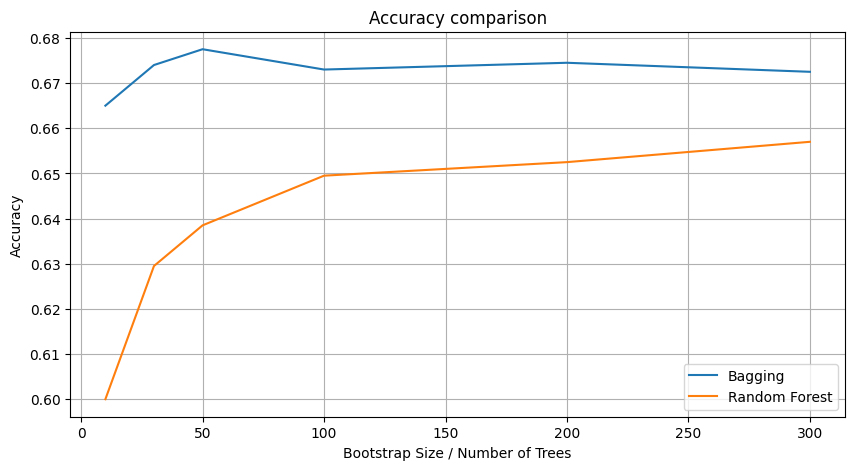

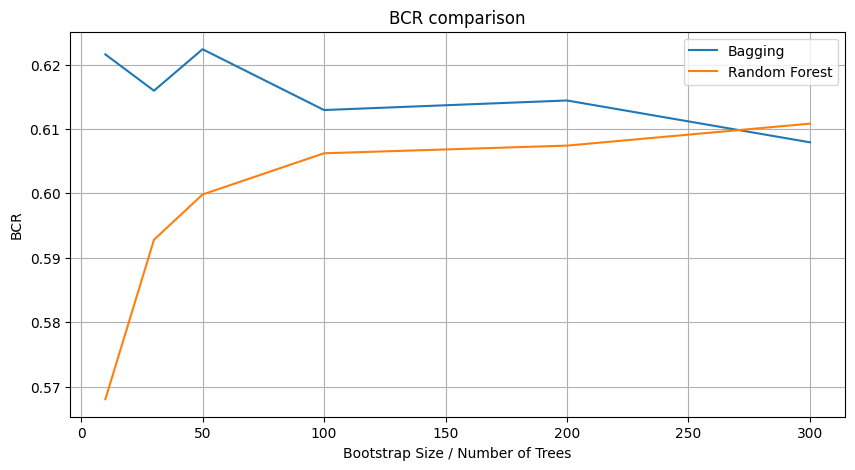

In [43]:
import matplotlib.pyplot as plt

# results_df1에서 ACC와 BCR 추출
bootstrap_sizes = results_df1['Bootstrap Size']
accuracy1 = results_df1['Accuracy']
bcr1 = results_df1['BCR']

# results_df2에서 ACC와 BCR 추출
num_trees = results_df2['# of Trees']
accuracy2 = results_df2['Accuracy']
bcr2 = results_df2['BCR']

# ACC 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(bootstrap_sizes, accuracy1, label='Bagging')
plt.plot(num_trees, accuracy2, label='Random Forest')
plt.xlabel('Bootstrap Size / Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy comparison')
plt.legend()
plt.grid(True)
plt.show()

# BCR 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(bootstrap_sizes, bcr1, label='Bagging')
plt.plot(num_trees, bcr2, label='Random Forest')
plt.xlabel('Bootstrap Size / Number of Trees')
plt.ylabel('BCR')
plt.title('BCR comparison')
plt.legend()
plt.grid(True)
plt.show()

최적의 모델에 대한 변수 중요도

In [44]:
# Variable Importance
var_imp = best_rf_model.feature_importances_

var_imp_df = pd.DataFrame(
    data = var_imp,
    columns = ['variables importance'],
    index = X_test.iloc[:].columns
).sort_values('variables importance', ascending=False)
var_imp_df

,variables importance
geo_level_3_id,0.130482
geo_level_1_id,0.129077
geo_level_2_id,0.125702
age,0.093476
area_percentage,0.092357
...,...
has_secondary_use_school,0.000045
has_secondary_use_institution,0.000031
has_secondary_use_gov_office,0.000029
has_secondary_use_industry,0.000014


<Axes: xlabel='variables importance', ylabel='None'>

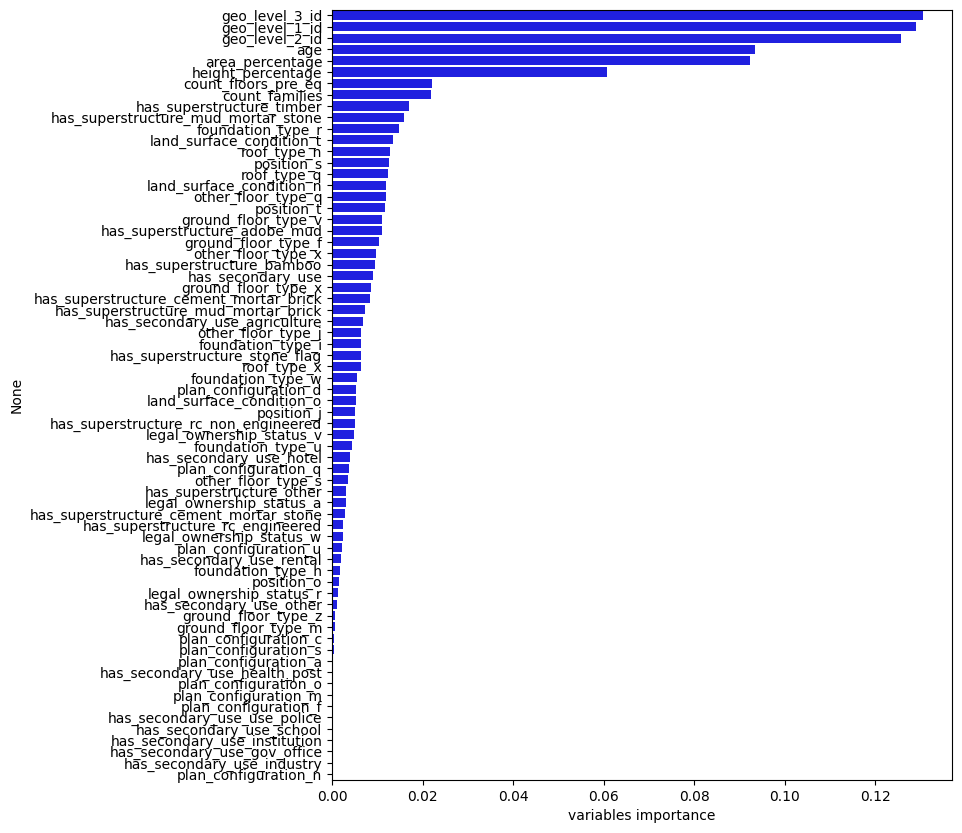

In [45]:
plt.figure(figsize=(8,10))
sns.barplot(
    x     = 'variables importance',
    y     = var_imp_df.index,
    color = 'blue',
    data  = var_imp_df
)

<Axes: xlabel='None', ylabel='variables importance'>

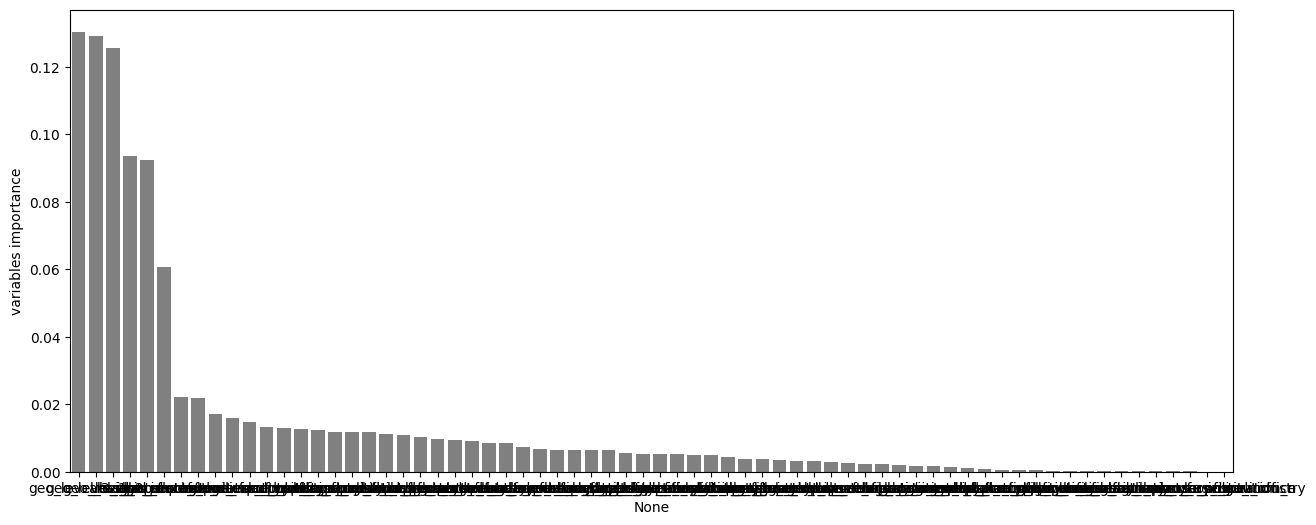

In [46]:
plt.figure(figsize=(15,6))
sns.barplot(
    x     = var_imp_df.index,
    y     = 'variables importance',
    color = 'grey',
    data  = var_imp_df
)

## Neural Network 단일모형 10번 반복

In [ ]:
print("Best parameters:", best_ann_params)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}


In [ ]:
# 반복 횟수 설정
num_repeats = 10

# 반복해서 얻은 ACC와 BCR 값 저장할 리스트 초기화
acc_scores = []
bcr_scores = []

# ANN 단일 모형 훈련 및 평가
for _ in range(num_repeats):
    model = MLPClassifier(**best_ann_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ann_cfm = confusion_matrix(y_test, y_pred)
    ACC, BCR = perf_eval(cm=ann_cfm)

    acc_scores.append(ACC)
    bcr_scores.append(BCR)

# 계산된 ACC와 BCR의 평균과 표준편차 계산
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
mean_bcr = np.mean(bcr_scores)
std_bcr = np.std(bcr_scores)

# 결과 출력
print("Mean Accuracy:", mean_acc)
print("Standard Deviation of Accuracy:", std_acc)
print("Mean BCR:", mean_bcr)
print("Standard Deviation of BCR:", std_bcr)

Mean Accuracy: 0.4314
Standard Deviation of Accuracy: 0.12695172310764433
Mean BCR: 0.43692196878560574
Standard Deviation of BCR: 0.10599218584968444


## Model 6: Bagging with Neural Network

In [ ]:
perf_table2 = pd.DataFrame(
    data    = np.zeros(shape=(1,2)),
    index   = ["bagging_ann"],
    columns = ["Accuracy", "BCR"]
)

In [ ]:
print("Best parameters:", best_ann_params)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}


In [ ]:
# 결과를 저장할 DataFrame 생성
results_df3 = pd.DataFrame(columns=['Bootstrap Size', 'Accuracy', 'BCR'])

# Bagging Training
best_ann_bagging_model = None
best_BCR = 0
best_bootstrap = 0

# 각 bootstrap 값에 대해 Bagging을 수행하여 가장 좋은 결과를 찾음
for bootstrap_size in [10, 30, 50, 100, 200, 300]:
    # Bagging Training
    bagging_ann_model = BaggingClassifier(
        base_estimator=MLPClassifier(**best_ann_params),
        n_estimators=bootstrap_size,
        n_jobs=8,
        bootstrap=True,
        random_state=42
    ).fit(X_train, y_train)

    y_pred = bagging_ann_model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 결과를 DataFrame에 추가
    new_row_index = len(results_df3)
    results_df3.loc[new_row_index] = [bootstrap_size, ACC, BCR]

    # 현재 bootstrap 값의 결과가 더 좋은 경우 최적 모델 및 결과 업데이트
    if BCR > best_BCR:
        best_BCR = BCR
        best_bootstrap = bootstrap_size
        best_ann_bagging_model = bagging_ann_model

# 전체 결과 출력
print(results_df3)

# 최적의 결과 출력
print("Best Bootstrap Size:", best_bootstrap)
print("Best BCR:", best_BCR)

cm = confusion_matrix(y_valid, best_ann_bagging_model.predict(X_valid))
print("Confusion matrix:\n", cm)

   Bootstrap Size  Accuracy       BCR
0            10.0    0.5755  0.279179
1            30.0    0.5780  0.474556
2            50.0    0.5735  0.368880
3           100.0    0.5720  0.360799
4           200.0    0.5730  0.348084
5           300.0    0.5725  0.348104
Best Bootstrap Size: 30
Best BCR: 0.474555819577831
Confusion matrix:
 [[ 37 155  15]
 [ 24 915 205]
 [  2 443 204]]


In [ ]:
# Bagging Test
bagging_ann_prey = best_ann_bagging_model.predict(X_test)
bagging_ann_cfm = confusion_matrix(y_test, bagging_ann_prey)
print("Confusion matrix:\n", bagging_ann_cfm)

Confusion matrix:
 [[ 27 144  15]
 [ 23 924 221]
 [  1 439 206]]


In [ ]:
perf_table2.iloc[0,:] = perf_eval(cm=bagging_ann_cfm)
perf_table2

,Accuracy,BCR
bagging_ann,0.5785,0.459394


In [ ]:
perf_table.loc["Bagging ANN"] = perf_eval(cm=bagging_ann_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306
Bagging CART,0.7015,0.643289
Random Forests,0.6735,0.615187
Bagging ANN,0.5785,0.459394


## Model 7: AdaBoost with Stump Tree

In [ ]:
perf_table2 = pd.DataFrame(
    data    = np.zeros(shape=(1,2)),
    index   = ["AdaBoost"],
    columns = ["Accuracy", "BCR"]
)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

In [ ]:
# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_adaboost_params = None
best_BCR = 0
best_adaboost_model = None

# 각 파라미터 조합에 대해 모델 훈련 및 평가
for params in grid:
    model = AdaBoostClassifier(random_state=12345, **params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 최고의 BCR 값을 가진 모델 및 파라미터 저장
    if BCR > best_BCR:
        best_BCR = BCR
        best_adaboost_params = params
        best_adaboost_model = model

# 최적 하이퍼파라미터 출력
print("Best parameters:", best_adaboost_params)
print("Best BCR on validation data:", best_BCR)

cm = confusion_matrix(y_valid, best_adaboost_model.predict(X_valid))
print("Confusion matrix:\n", cm)

Best parameters: {'learning_rate': 1.0, 'n_estimators': 200}
Best BCR on validation data: 0.6040093112801705
Confusion matrix:
 [[ 78 127   2]
 [ 52 934 158]
 [  4 364 281]]


In [ ]:
# 테스트 데이터에 대한 최적 모델 평가
y_pred = best_adaboost_model.predict(X_test)
adaboost_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", adaboost_cfm)

Confusion matrix:
 [[ 76 108   2]
 [ 56 948 164]
 [  1 361 284]]


In [ ]:
perf_table2.iloc[0,:] = perf_eval(cm=adaboost_cfm)
perf_table2

,Accuracy,BCR
AdaBoost,0.654,0.615082


In [ ]:
perf_table.loc["AdaBoost"] = perf_eval(cm=adaboost_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306
Bagging CART,0.7015,0.643289
Random Forests,0.6735,0.615187
Bagging ANN,0.5785,0.459394
AdaBoost,0.6540,0.615082


## Model 8: Gradient Boosting Machine

In [ ]:
perf_table2 = pd.DataFrame(
    data    = np.zeros(shape=(1,2)),
    index   = ["GBM"],
    columns = ["Accuracy", "BCR"]
)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [5, 7, 10],
    'subsample': [0.7, 0.8, 0.9]
}

In [ ]:
# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 최적 하이퍼파라미터 및 최고 점수 초기화
best_gbm_params = None
best_BCR = 0
best_ann_model = None

# 각 파라미터 조합에 대해 모델 훈련 및 평가
for params in grid:
    model = GradientBoostingClassifier(random_state=12345, **params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    ACC, BCR = perf_eval(cm=cm)

    # 최고의 BCR 값을 가진 모델 및 파라미터 저장
    if BCR > best_BCR:
        best_BCR = BCR
        best_gbm_params = params
        best_gbm_model = model

# 최적 하이퍼파라미터 출력
print("Best parameters:", best_gbm_params)
print("Best BCR on validation data:", best_BCR)

cm = confusion_matrix(y_valid, best_gbm_model.predict(X_valid))
print("Confusion matrix:\n", cm)

Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best BCR on validation data: 0.6425358074267912
Confusion matrix:
 [[ 86 115   6]
 [ 67 853 224]
 [  8 290 351]]


In [ ]:
# 테스트 데이터에 대한 최적 모델 평가
y_pred = best_gbm_model.predict(X_test)
gbm_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", gbm_cfm)

Confusion matrix:
 [[ 73 104   9]
 [ 61 894 213]
 [  8 248 390]]


In [ ]:
perf_table2.iloc[0,:] = perf_eval(cm=gbm_cfm)
perf_table2

,Accuracy,BCR
GBM,0.6785,0.663136


In [ ]:
perf_table.loc["GBM"] = perf_eval(cm=gbm_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306
Bagging CART,0.7015,0.643289
Random Forests,0.6735,0.615187
Bagging ANN,0.5785,0.459394
AdaBoost,0.6540,0.615082
GBM,0.6785,0.663136


In [ ]:
# Variable Importance
var_imp = best_gbm_model.feature_importances_

var_imp_df = pd.DataFrame(
    data = var_imp,
    columns = ['variables importance'],
    index = X_test.iloc[:].columns
).sort_values('variables importance', ascending=False)
var_imp_df

,variables importance
geo_level_3_id,0.188394
geo_level_2_id,0.172993
geo_level_1_id,0.169598
age,0.073972
area_percentage,0.069832
...,...
has_secondary_use_institution,0.000022
plan_configuration_f,0.000000
plan_configuration_n,0.000000
has_secondary_use_school,0.000000


<Axes: xlabel='variables importance', ylabel='None'>

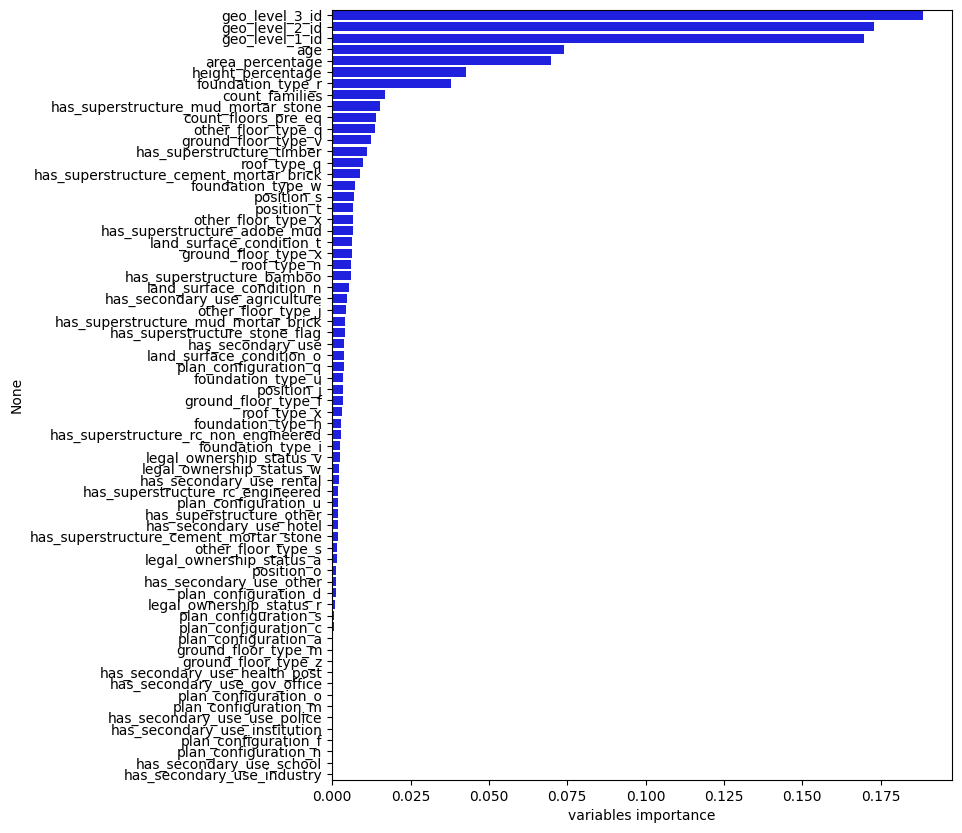

In [ ]:
plt.figure(figsize=(8,10))
sns.barplot(
    x     = 'variables importance',
    y     = var_imp_df.index,
    color = 'blue',
    data  = var_imp_df
)

## Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# RandomOverSampler 객체 생성
over_sampler = RandomOverSampler(random_state=42)

# 클래스 1과 클래스 3에 해당하는 샘플을 오버샘플링하여 데이터셋을 재구성
X_resampled, y_resampled = over_sampler.fit_resample(X_train, y_train)

# 오버샘플링된 데이터셋 크기 확인
print("샘플링 전 클래스별 샘플 개수:", Counter(y_train))
print("샘플링 후 클래스별 샘플 개수:", Counter(y_resampled))

샘플링 전 클래스별 샘플 개수: Counter({2: 3430, 3: 1973, 1: 597})
샘플링 후 클래스별 샘플 개수: Counter({2: 3430, 3: 3430, 1: 3430})


In [ ]:
print("Best parameters:", best_gbm_params)

Best parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
perf_table2 = pd.DataFrame(
    data    = np.zeros(shape=(1,2)),
    index   = ["Re-GBM"],
    columns = ["Accuracy", "BCR"]
)

In [ ]:
model = GradientBoostingClassifier(random_state=12345, **best_gbm_params)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
ACC, BCR = perf_eval(cm=cm)

print("ACC on validation data:", ACC)
print("BCR on validation data:", BCR)
print("Confusion matrix:\n", cm)

ACC on validation data: 0.6425
BCR on validation data: 0.6669883225231762
Confusion matrix:
 [[101 102   4]
 [ 81 809 254]
 [ 11 263 375]]


In [ ]:
# 테스트 데이터에 대한 최적 모델 평가
y_pred = model.predict(X_test)
gbm_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", gbm_cfm)

Confusion matrix:
 [[ 83  94   9]
 [ 78 859 231]
 [ 10 241 395]]


In [ ]:
perf_table2.iloc[0,:] = perf_eval(cm=gbm_cfm)
perf_table2

,Accuracy,BCR
Re-GBM,0.6685,0.674565


In [ ]:
perf_table.loc["Re-GBM"] = perf_eval(cm=gbm_cfm)
perf_table

,Accuracy,BCR
MLR,0.6075,0.483311
CART,0.6575,0.631683
ANN,0.5520,0.573306
Bagging CART,0.7015,0.643289
Random Forests,0.6735,0.615187
Bagging ANN,0.5785,0.459394
AdaBoost,0.6540,0.615082
GBM,0.6785,0.663136
Re-GBM,0.6685,0.674565
